In [1]:
import numpy as np
import netCDF4 as nc

In [2]:
# fp = 'data/sst.mon.ltm.1991-2020.nc'
fp = 'data/sst.mnmean.nc'
ds = nc.Dataset(fp)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    climatology: Climatology is based on 1971-2000 SST, Xue, Y., T. M. Smith, and R. W. Reynolds, 2003: Interdecadal changes of 30-yr SST normals during 1871.2000. Journal of Climate, 16, 1601-1612.
    description: In situ data: ICOADS2.5 before 2007 and NCEP in situ data from 2008 to present. Ice data: HadISST ice before 2010 and NCEP ice after 2010.
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    keywords: Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature >
    instrument: Conventional thermometers
    source_comment: SSTs were observed by conventional thermometers in Buckets (insulated or un-insulated canvas and wooded buckets) or Engine Room Intaker
    geospatial_lon_min: -1.0
    geospatial_lon_max: 359.0
    geospatial_laty_max: 89.0
    geospatial_laty_min: -89.0
    geospatial_lat_max: 89.0
    geospatial_lat_min: -89.0
    

In [3]:
ds.variables.keys()

dict_keys(['lat', 'lon', 'time_bnds', 'time', 'sst'])

In [4]:
ds.variables['sst'].long_name

'Monthly Means of Sea Surface Temperature'

In [5]:
ds.variables['time_bnds'].long_name

'Time Boundaries'

In [6]:
ds.variables['time']

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: days since 1800-1-1 00:00:00
    long_name: Time
    delta_t: 0000-01-00 00:00:00
    avg_period: 0000-01-00 00:00:00
    prev_avg_period: 0000-00-07 00:00:00
    standard_name: time
    axis: T
    actual_range: [19723. 81722.]
unlimited dimensions: time
current shape = (2038,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [7]:
ds['sst'][200,10,10]

masked

In [8]:
import xarray as xr

In [9]:
ds = xr.open_dataset(fp)
df = ds.to_dataframe()
# df = df.reset_index(level=[0,1])
# df = df.reset_index()

In [10]:
df.head()

time_bnds  sst
lat  lon time       nbnds                   
88.0 0.0 1854-01-01 0      9.969210e+36 -1.8
                    1      9.969210e+36 -1.8
         1854-02-01 0      9.969210e+36 -1.8
                    1      9.969210e+36 -1.8
         1854-03-01 0      9.969210e+36 -1.8

In [11]:
df = df.reset_index()
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
1,88.0,0.0,1854-01-01,1,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
3,88.0,0.0,1854-02-01,1,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8


In [22]:
df.to_csv('data/sst.csv')

In [12]:
df.shape

(65297520, 6)

In [13]:
ds.variables['sst']

<xarray.Variable (time: 2038, lat: 89, lon: 180)>
array([[[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ...,

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]], dtype=float32)
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [14]:
df['lat'].unique()

array([ 88.,  86.,  84.,  82.,  80.,  78.,  76.,  74.,  72.,  70.,  68.,
        66.,  64.,  62.,  60.,  58.,  56.,  54.,  52.,  50.,  48.,  46.,
        44.,  42.,  40.,  38.,  36.,  34.,  32.,  30.,  28.,  26.,  24.,
        22.,  20.,  18.,  16.,  14.,  12.,  10.,   8.,   6.,   4.,   2.,
         0.,  -2.,  -4.,  -6.,  -8., -10., -12., -14., -16., -18., -20.,
       -22., -24., -26., -28., -30., -32., -34., -36., -38., -40., -42.,
       -44., -46., -48., -50., -52., -54., -56., -58., -60., -62., -64.,
       -66., -68., -70., -72., -74., -76., -78., -80., -82., -84., -86.,
       -88.], dtype=float32)

In [15]:
df['lon'].unique()

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284.,
       286., 288., 290., 292., 294., 296., 298., 30

In [16]:
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd

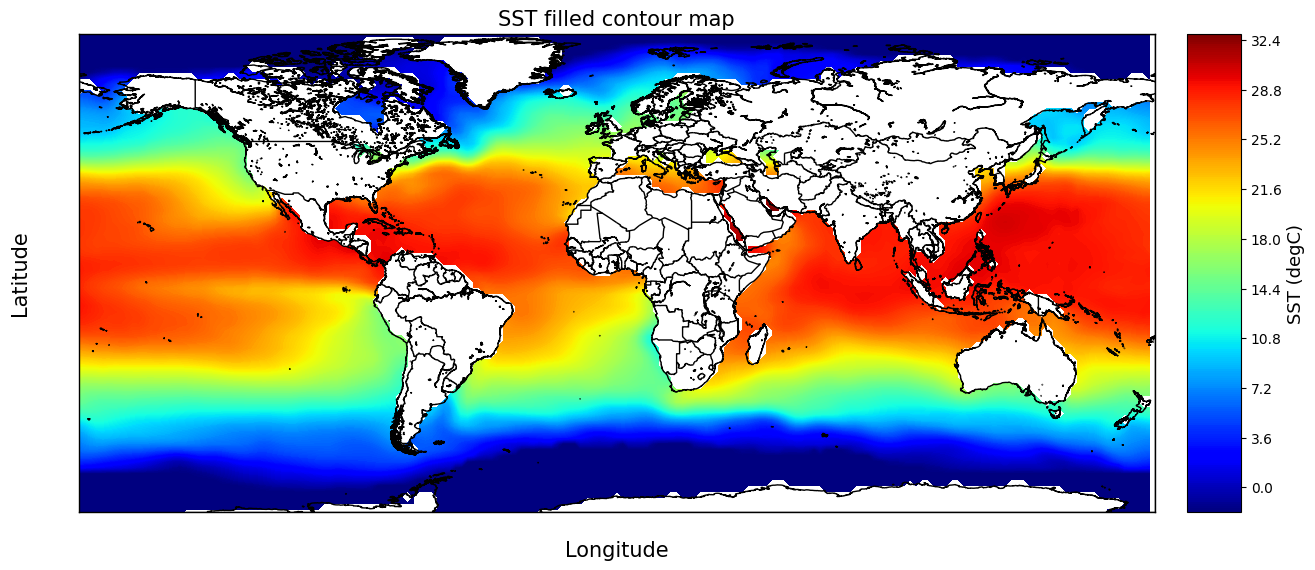

In [17]:
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]
sst = ds.variables['sst'][:]

###  Section added ################
# map lon values to -180..180 range

# rearange data
ind = np.argsort(lons)
lons = lons[ind]
sst = sst[:, :, ind]

##################################


fig = plt.figure(num=None, figsize=(15, 15) ) 
m = Basemap(projection='cyl', llcrnrlon=-180, llcrnrlat=-75, urcrnrlon=180, urcrnrlat=85, resolution='i')

lon, lat = np.meshgrid(lons,lats)

x, y = m(lon, lat)

st = np.squeeze(sst[200,:,:])
# cs = m.pcolor(x, y , st, cmap='jet')
cs = m.contourf(x, y , st, cmap='jet', levels = 300)
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 
# m.drawmeridians(range(-80, -25, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 0, 1])
# m.drawparallels(range(-50, 20, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 0, 0, 0])
plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)
cbar = m.colorbar(cs, location='right', pad="3%")
cbar.set_label('SST (degC)', fontsize=13)
plt.title('SST filled contour map', fontsize=15)
plt.show()

In [28]:
def print_sst_map(ds, day):
    lats = ds.variables['lat'][:]
    lons = ds.variables['lon'][:]
    sst = ds.variables['sst'][:]
    f = lambda x: ((x+180) % 360) - 180
    lons = f(lons)

    ind = np.argsort(lons)
    lons = lons[ind]
    sst = sst[:, :, ind]

    fig = plt.figure(num=None, figsize=(15, 15) ) 
    m = Basemap(projection='cyl', llcrnrlon=-180, llcrnrlat=-75, urcrnrlon=180, urcrnrlat=85, resolution='i')

    lon, lat = np.meshgrid(lons,lats)

    x, y = m(lon, lat)

    st = np.squeeze(sst[day,:,:])
    # cs = m.pcolor(x, y , st, cmap='jet')
    cs = m.contourf(x, y , st, cmap='jet', levels = 300)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 
    # m.drawmeridians(range(-80, -25, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 0, 1])
    # m.drawparallels(range(-50, 20, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 0, 0, 0])
    plt.ylabel("Latitude", fontsize=15, labelpad=35)
    plt.xlabel("Longitude", fontsize=15, labelpad=20)
    cbar = m.colorbar(cs, location='right', pad="3%")
    cbar.set_label('SST (degC)', fontsize=13)
    plt.title('SST filled contour map', fontsize=15)
    plt.show()

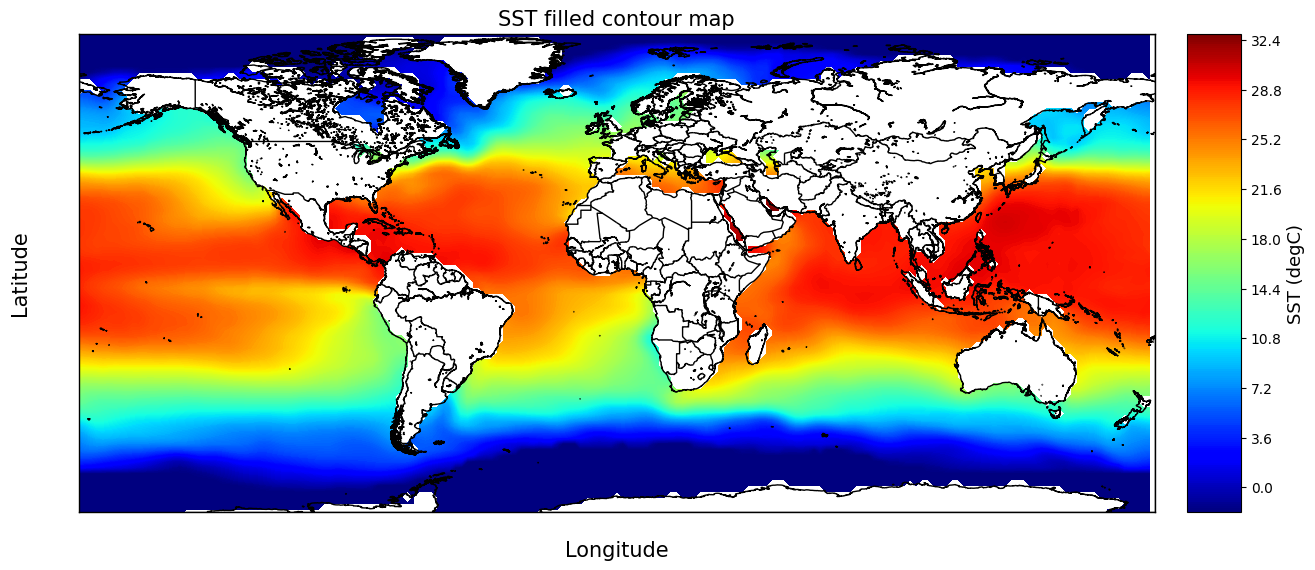

In [29]:
print_sst_map(ds, 200)

In [20]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
1,88.0,0.0,1854-01-01,1,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
3,88.0,0.0,1854-02-01,1,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8


In [21]:
df['time']

0          1854-01-01
1          1854-01-01
2          1854-02-01
3          1854-02-01
4          1854-03-01
              ...    
65297515   2023-08-01
65297516   2023-09-01
65297517   2023-09-01
65297518   2023-10-01
65297519   2023-10-01
Name: time, Length: 65297520, dtype: datetime64[ns]

In [31]:
print(np.max(df['sst']))
print(np.min(df['sst']))

42.32636
-1.8


In [32]:
from dtw import

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [39]:
point_df = df[(df['lat'] == 80) & (df['lon'] == 40)]

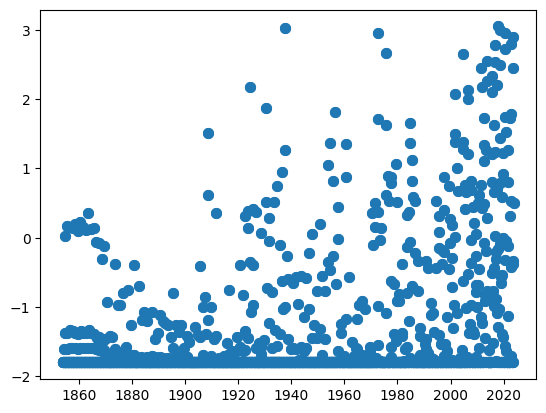

In [42]:
fig, ax = plt.subplots()
ax.plot(point_df['time'], point_df['sst'], linewidth=2.0)
plt.show()

fig, ax = plt.subplots()
ax.plot(point_df[''], y, linewidth=2.0)
plt.show()
plt.plot(point_df['sst'])

In [ ]:
alignment = dtw(df['sst'], template, keep_internals=True)